In [1]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
import glob

### Part 1: Extract license plate from sample image

In [2]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [3]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [4]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [12]:
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

In [11]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = image_path
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

In [13]:
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

1/1 [==============================] - 2s 2s/step
labels1 [<local_utils.DLabel object at 0x000001C3130F0D00>, <local_utils.DLabel object at 0x000001C3130EA4F0>]
labels2 [<local_utils.DLabel object at 0x000001C3130F0CD0>, <local_utils.DLabel object at 0x000001C3130EA5E0>]
outsize (470, 110)
lptype 1
Detectado 7 letras...
1/1 [==============================] - 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KZH4997
1/1 [==============================] - 1s 1s/step
labels1 [<local_utils.DLabel object at 0x000001C30371B760>, <local_utils.DLabel object at 0x000001C30373D280>]
labels2 [<local_utils.DLabel object at 0x000001C30371B280>, <local_utils.DLabel object at 0x000001C30371BEB0>]
outsize (470, 110)
lptype 1
Detectado 7 letras...
1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KZH4997
1/1 [==============================] - 2s 2s/step
labels1 [<local_utils.DLabel object at 0x000001C31310CDF0>, <local_utils.DLabel object at 0x000001C3130FC520>, <local_utils.DLabel object at 0x000001C30373DA90>]
labels2 [<local_utils.DLabel object at 0x000001C31310C580>, <local_utils.DLabel object at 0x000001C3130FC4F0>, <local_utils.DLabel object at 0x000001C30379C820>]
outsize (470, 110)
lptype 1
Detectado 5 letras...
1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ZH499
1/1 [==============================] - 1s 1s/step
labels1 [<local_utils.DLabel object at 0x000001C3037EBE50>, <local_utils.DLabel object at 0x000001C30380C250>, <local_utils.DLabel object at 0x000001C3038134C0>]
labels2 [<local_utils.DLabel object at 0x000001C3037EBD90>, <local_utils.DLabel object at 0x000001C30380CA60>, <local_utils.DLabel object at 0x000001C303804880>]
outsize (470, 110)
lptype 1
Detectado 6 letras...
1/1 [==============================] - 0s 69ms/step
KZH499


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

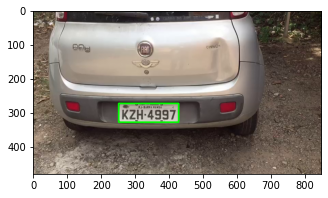

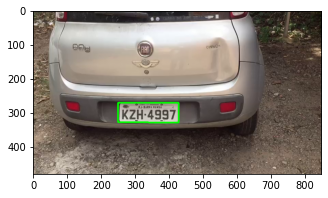

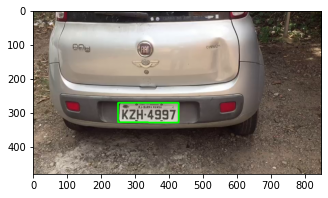

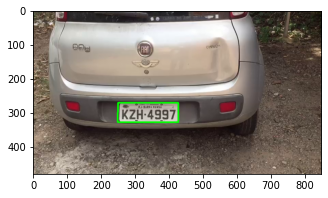

In [14]:


input_path = r'../video.mp4'
cap = cap = cv2.VideoCapture(input_path)
while cv2.waitKey(1) < 0:
    hasFrame, frame = cap.read()   
    if not hasFrame:
        print("Done processing !!!")
        break

    resize=False
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(frame, (224,224))
    Dmax=608
    Dmin = 608
    vehicle = img
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    a, LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    frames = draw_box(vehicle,cor)    
    if (len(LpImg)): #check if there is at least one license image
        plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(7,7),0)
        binary = cv2.threshold(blur, 180, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    test_roi = plate_image.copy()
    crop_characters = []
    digit_w, digit_h = 30, 60
    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 1<=ratio<=3.5: # Only select contour with defined ratio
            if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
                # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                # Sperate number and gibe prediction
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                crop_characters.append(curr_num)

    print("Detectado {} letras...".format(len(crop_characters)))
    fig = plt.figure(figsize=(15,3))
    cols = len(crop_characters)
    grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

    final_string = ''
    for i,character in enumerate(crop_characters):
        title = np.array2string(predict_from_model(character,model,labels))
        final_string+=title.strip("'[]")
    print(final_string)

    plt.imshow(frames)

